In [8]:
import pandas as pd
import os
from google.colab import drive
from scipy import stats
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler

drive.mount('/content/drive', force_remount=True)
path = '/content/drive/MyDrive/Psychologia/Magisterka/magisterka Psyche/Mateusz_Kamyczura_Praca_Magisterska/Praca Magisterska/Kody i Dane/Baza danych'
Output_path = path + '/Output'

Mounted at /content/drive


In [9]:
zasadyABC = pd.read_excel(Output_path + '/zasadyABC.xlsx')
zasadyXYZ = pd.read_excel(Output_path + '/zasadyXYZ.xlsx')

In [10]:
pewnoscABC = pd.read_excel(Output_path + '/pewnoscABC.xlsx')
pewnoscXYZ = pd.read_excel(Output_path + '/pewnoscXYZ.xlsx')

In [11]:

def wykres_rozk≈Çadu(df):
    # Sprawdzamy, czy kolumny istniejƒÖ w dataframe
    if 'CzyPoprawna' not in df.columns or 'OSAD' not in df.columns:
        print("Brak wymaganych kolumn w DataFrame!")
        return

    # Filtrowanie danych, aby uwzglƒôdniƒá tylko wiersze, gdzie CzyPoprawna == 1 lub CzyPoprawna == -1
    df = df[df['CzyPoprawna'].isin([1, -1])]

    # Grupujemy dane po 'CzyPoprawna'
    grupy = df.groupby('CzyPoprawna')

    # Tworzymy wykresy dla ka≈ºdej z grup
    plt.figure(figsize=(11, 5))

    for idx, (value, grupa) in enumerate(grupy, 1):
        plt.subplot(1, 2, idx)
        sns.histplot(grupa['OSAD'], kde=True, bins=30, color='blue' if value == 1 else 'red')
        if (idx == 1):
            plt.title(f"Rozk≈Çad poziomu pewno≈õci w≈õr√≥d niepoprawnych odpowiedzi")
        else:
            plt.title(f"Rozk≈Çad poziomu pewno≈õci w≈õr√≥d poprawnych odpowiedzi")
        plt.xlabel('Poziom Pewno≈õci')
        plt.ylabel('Liczba obserwacji')

    # Wy≈õwietlamy wykresy
    plt.tight_layout()
    plt.show()


def wykres_rozk≈Çadu_osad(df):
    # Sprawdzamy, czy kolumny istniejƒÖ w dataframe
    if 'G' not in df.columns or 'OSAD' not in df.columns:
        print("Brak wymaganych kolumn w DataFrame!")
        return

    # Filtrowanie danych, aby uwzglƒôdniƒá tylko wiersze, gdzie G == 0 lub G == 1
    df = df[df['G'].isin([0, 1])]

    # Grupujemy dane po 'G'
    grupy = df.groupby('G')

    # Tworzymy wykresy dla ka≈ºdej z grup
    plt.figure(figsize=(11, 5))

    for idx, (value, grupa) in enumerate(grupy, 1):
        plt.subplot(1, 2, idx)
        sns.histplot(grupa['OSAD'], kde=True, bins=30, color='blue' if value == 1 else 'green')
        if (idx == 1):
            plt.title(f"Rozk≈Çad poziomu pewno≈õci w≈õr√≥d niegramatycznych pozycji")
        else:
            plt.title(f"Rozk≈Çad poziomu pewno≈õci w≈õr√≥d gramatycznych pozycji")
        plt.xlabel('Poziom Pewno≈õci')
        plt.ylabel('Liczba obserwacji')

    # Wy≈õwietlamy wykresy
    plt.tight_layout()
    plt.show()

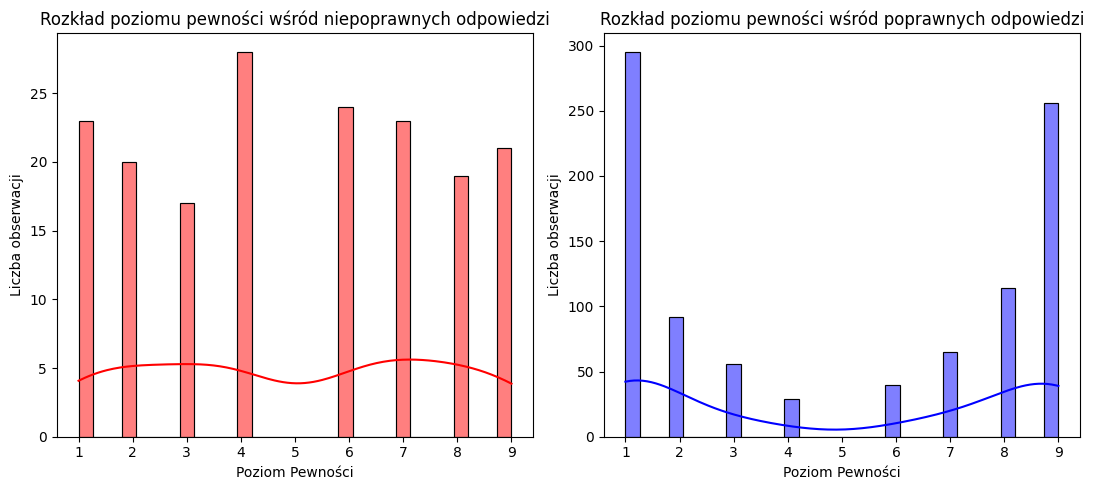

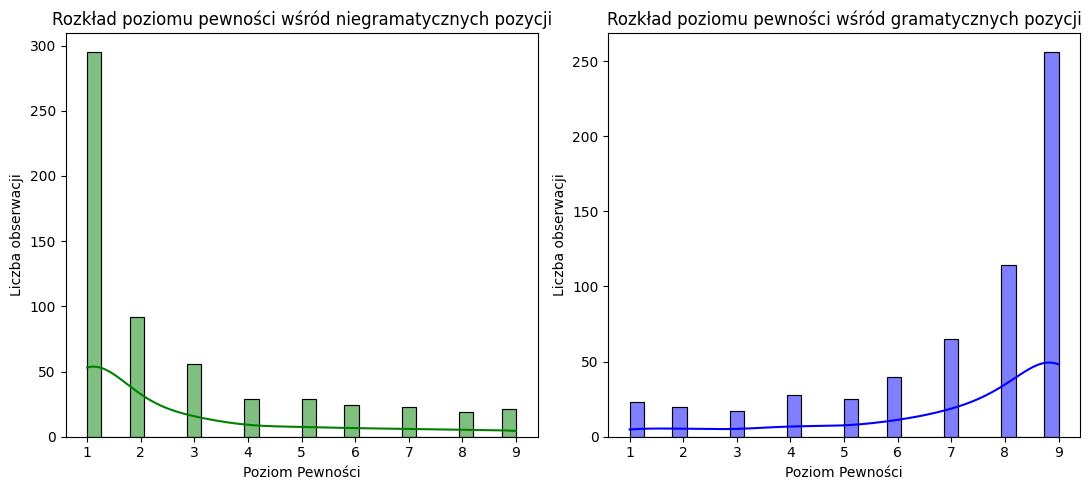

In [12]:

wykres_rozk≈Çadu(pewnoscABC)
wykres_rozk≈Çadu_osad(pewnoscABC)

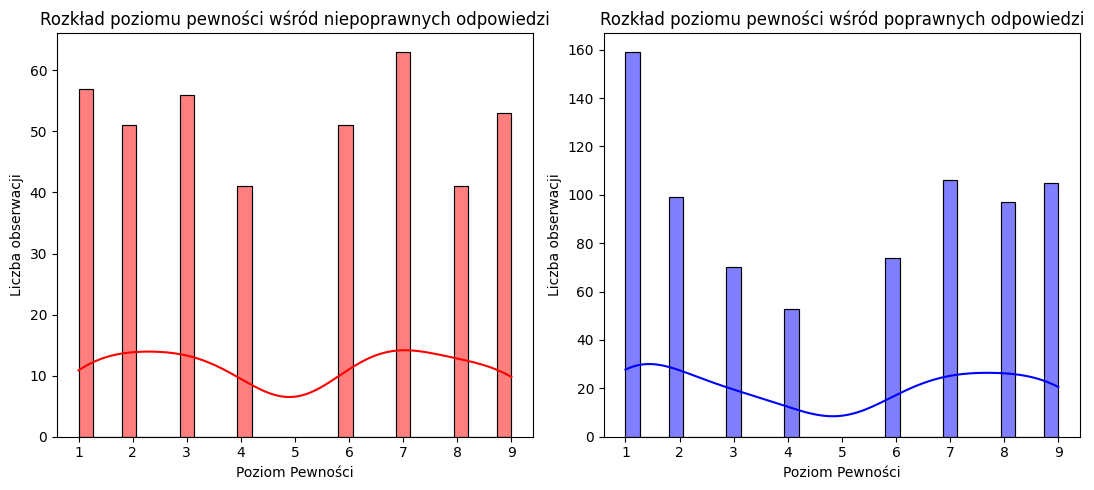

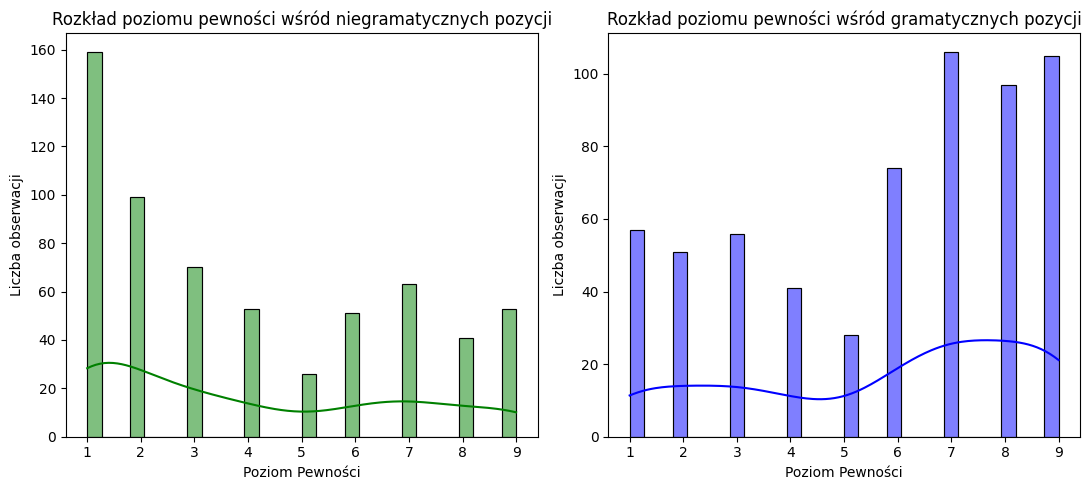

In [13]:

wykres_rozk≈Çadu(pewnoscXYZ)
wykres_rozk≈Çadu_osad(pewnoscXYZ)

In [14]:
def proporcja_gramatycznych_dla_kolumny_z_wykresem(df, kolumna_pewnosci):
    """
    Oblicza proporcjƒô gramatycznych odpowiedzi (G=1) dla ka≈ºdej warto≈õci w podanej kolumnie pewno≈õci
    i rysuje wykres s≈Çupkowy z na≈Ço≈ºonƒÖ liniƒÖ regresji oraz wy≈õwietla standaryzowanƒÖ betƒô (Œ≤)
    i odchylenia standardowe obu zmiennych.

    Parametry:
    df (pd.DataFrame): DataFrame zawierajƒÖcy kolumny 'G' oraz kolumnƒô z poziomem pewno≈õci.
    kolumna_pewnosci (str): Nazwa kolumny zawierajƒÖcej poziomy pewno≈õci.

    Zwraca:
    pd.DataFrame: DataFrame z proporcjami i danymi dla regresji.
    """
    # Agregacja danych
    grouped = df.groupby(kolumna_pewnosci)['G'].agg(['count', 'sum'])
    #print(grouped)
    grouped.columns = ['Liczba_wszystkich', 'Liczba_gramatycznych']
    grouped['Proporcja_gramatycznych'] = grouped['Liczba_gramatycznych'] / grouped['Liczba_wszystkich']
    grouped = grouped.reset_index()
    wyniki_proporcji = grouped[[kolumna_pewnosci, 'Liczba_wszystkich', 'Liczba_gramatycznych', 'Proporcja_gramatycznych']]
    print(wyniki_proporcji)

    # Obliczanie SD dla interpretacji bety
    sd_x = wyniki_proporcji[kolumna_pewnosci].std()
    sd_y = wyniki_proporcji['Proporcja_gramatycznych'].std()

    # Regresja klasyczna (B)
    X = sm.add_constant(wyniki_proporcji[kolumna_pewnosci])
    y = wyniki_proporcji['Proporcja_gramatycznych']
    model = sm.OLS(y, X).fit()

    # Regresja na danych standaryzowanych (Beta)
    scaler = StandardScaler()
    X_std = scaler.fit_transform(wyniki_proporcji[[kolumna_pewnosci]])
    y_std = scaler.fit_transform(y.values.reshape(-1, 1)).flatten()
    X_std = sm.add_constant(X_std)
    model_std = sm.OLS(y_std, X_std).fit()

    # Pobieranie warto≈õci bety i R¬≤
    beta = model_std.params[1]
    beta_se = model_std.bse[1]
    r_squared = model.rsquared

    # Wyniki regresji
    print(f"\nWyniki regresji liniowej dla kolumny: {kolumna_pewnosci}")
    print(model.summary())
    print(f"\nStandaryzowana beta (Œ≤): {beta:.3f}, SE = {beta_se:.3f}, R¬≤ = {r_squared:.3f}")


    # Wykres s≈Çupkowy + regresja
    plt.figure(figsize=(10, 6))
    plt.bar(wyniki_proporcji[kolumna_pewnosci], wyniki_proporcji['Proporcja_gramatycznych'], color='skyblue', label='Proporcja gramatycznych')
    plt.plot(wyniki_proporcji[kolumna_pewnosci], model.predict(X), color='red', label=f'Regresja: y={model.params[1]:.2f}x + {model.params[0]:.2f}')
    plt.xlabel('Poziom Pewno≈õci')
    plt.ylabel('Proporcja odpowiedzi gramatycznych')
    plt.xticks(wyniki_proporcji[kolumna_pewnosci])
    plt.grid(axis='y', linestyle='--')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return wyniki_proporcji


   OSAD  Liczba_wszystkich  Liczba_gramatycznych  Proporcja_gramatycznych
0     1                318                    23                 0.072327
1     2                112                    20                 0.178571
2     3                 73                    17                 0.232877
3     4                 57                    28                 0.491228
4     5                 54                    25                 0.462963
5     6                 64                    40                 0.625000
6     7                 88                    65                 0.738636
7     8                133                   114                 0.857143
8     9                277                   256                 0.924188

Wyniki regresji liniowej dla kolumny: OSAD
                               OLS Regression Results                              
Dep. Variable:     Proporcja_gramatycznych   R-squared:                       0.980
Model:                                 OLS   Adj

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=9 observations were given.
  return hypotest_fun_in(*args, **kwds)
<ipython-input-14-3298744975>:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(wyniki_proporcji[kolumna_pewnosci], model.predict(X), color='red', label=f'Regresja: y={model.params[1]:.2f}x + {model.params[0]:.2f}')


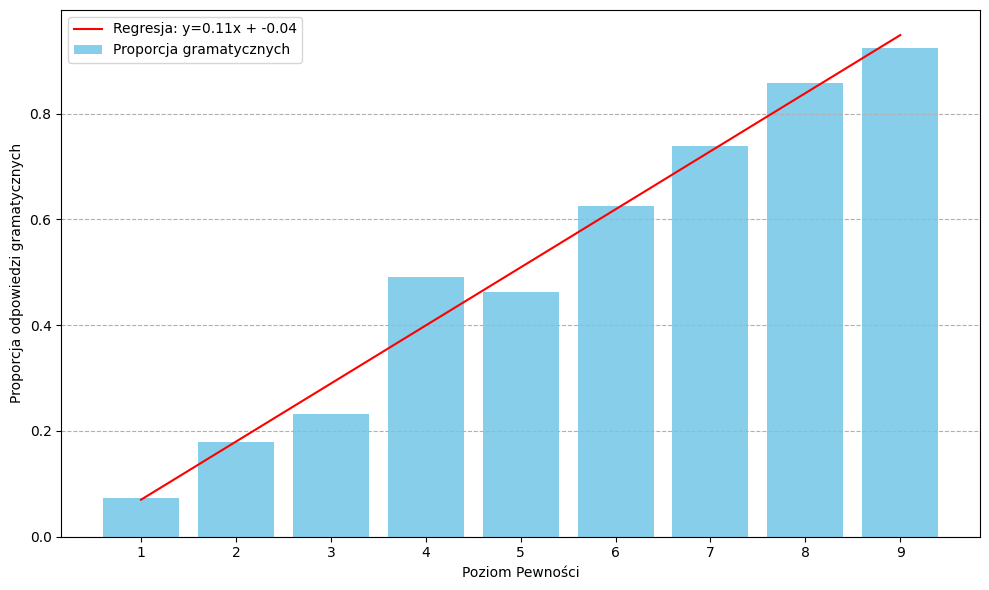

In [15]:
regABC = proporcja_gramatycznych_dla_kolumny_z_wykresem(pewnoscABC, 'OSAD')


   OSAD  Liczba_wszystkich  Liczba_gramatycznych  Proporcja_gramatycznych
0     1                216                    57                 0.263889
1     2                150                    51                 0.340000
2     3                126                    56                 0.444444
3     4                 94                    41                 0.436170
4     5                 54                    28                 0.518519
5     6                125                    74                 0.592000
6     7                169                   106                 0.627219
7     8                138                    97                 0.702899
8     9                158                   105                 0.664557

Wyniki regresji liniowej dla kolumny: OSAD
                               OLS Regression Results                              
Dep. Variable:     Proporcja_gramatycznych   R-squared:                       0.951
Model:                                 OLS   Adj

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=9 observations were given.
  return hypotest_fun_in(*args, **kwds)
<ipython-input-14-3298744975>:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(wyniki_proporcji[kolumna_pewnosci], model.predict(X), color='red', label=f'Regresja: y={model.params[1]:.2f}x + {model.params[0]:.2f}')


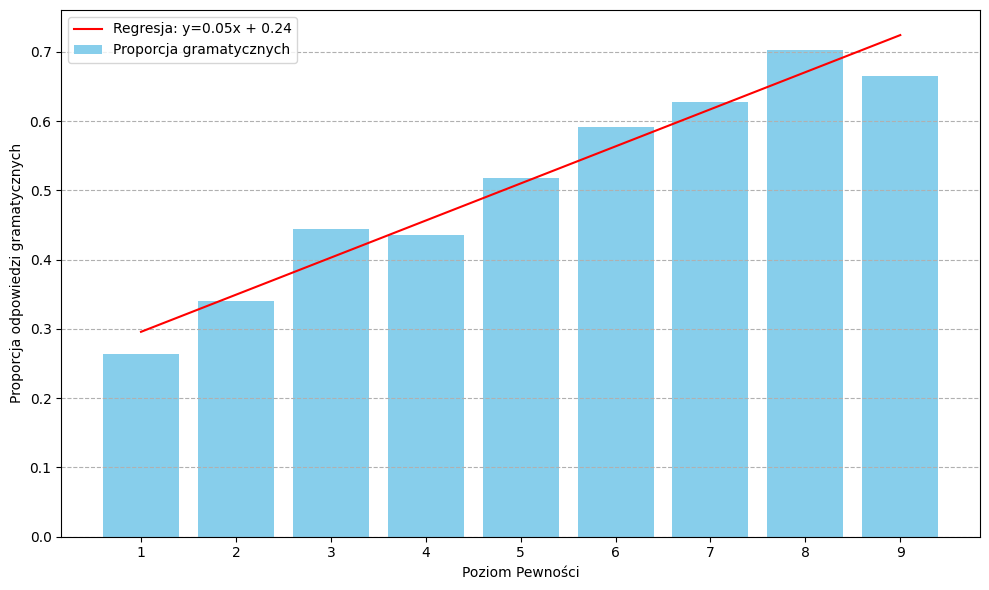

In [16]:
regXYZ = proporcja_gramatycznych_dla_kolumny_z_wykresem(pewnoscXYZ, 'OSAD')

In [17]:

def porownaj_dwie_regresje(df1, df2, kolumna_pewnosci):
    """
    Por√≥wnuje dwie regresje liniowe proporcji gramatycznych odpowiedzi wzglƒôdem poziomu pewno≈õci.

    Parametry:
    df1, df2 (pd.DataFrame): Dwa DataFrame'y zawierajƒÖce kolumny 'G' (1 - gramatyczna, 0 - niegramatyczna)
                             oraz kolumnƒô z poziomem pewno≈õci.
    kolumna_pewnosci (str): Nazwa kolumny zawierajƒÖcej poziomy pewno≈õci.

    Zwraca:
    pd.DataFrame, pd.DataFrame: Tabele z proporcjami dla ka≈ºdej z grup.
    """
    def oblicz_proporcje(df):
        grouped = df.groupby(kolumna_pewnosci)['G'].agg(['count', 'sum'])
        grouped.columns = ['Liczba_wszystkich', 'Liczba_gramatycznych']
        grouped['Proporcja_gramatycznych'] = grouped['Liczba_gramatycznych'] / grouped['Liczba_wszystkich']
        return grouped.reset_index()

    wyniki1 = oblicz_proporcje(df1)
    wyniki2 = oblicz_proporcje(df2)

    # Regresja dla obu grup
    X1 = sm.add_constant(wyniki1[kolumna_pewnosci])
    y1 = wyniki1['Proporcja_gramatycznych']
    model1 = sm.OLS(y1, X1).fit()

    X2 = sm.add_constant(wyniki2[kolumna_pewnosci])
    y2 = wyniki2['Proporcja_gramatycznych']
    model2 = sm.OLS(y2, X2).fit()

    # Wy≈õwietlenie wynik√≥w regresji
    print("\n--- Regresja dla Modelu ABC ---")
    print(model1.summary())
    print("\n--- Regresja dla Modelu XYZ ---")
    print(model2.summary())

    # Por√≥wnanie nachyle≈Ñ
    b1, se1 = model1.params[1], model1.bse[1]
    b2, se2 = model2.params[1], model2.bse[1]
    t_stat = (b1 - b2) / ((se1**2 + se2**2)**0.5)
    df = len(df1) + len(df2) - 4  # przybli≈ºone df
    p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=df))

    # Obliczenie wielko≈õci efektu d Cohena (przybli≈ºenie)
    d_cohen = (2 * abs(t_stat)) / (df ** 0.5)

    print(f"\nPor√≥wnanie nachyle≈Ñ:")
    print(f"Nachylenie Model ABC: {b1:.4f}, SE: {se1:.4f}")
    print(f"Nachylenie Model XYZ: {b2:.4f}, SE: {se2:.4f}")
    print(f"T-statystyka: {t_stat:.4f}, p-value: {p_value:.4f}")
    print(f"Wielko≈õƒá efektu (d Cohena) dla r√≥≈ºnicy nachyle≈Ñ: {d_cohen:.4f}")

    # Wykres
    plt.figure(figsize=(10, 6))
    plt.bar(wyniki1[kolumna_pewnosci]-0.2, wyniki1['Proporcja_gramatycznych'], width=0.4, label='Model ABC', color='skyblue')
    plt.bar(wyniki2[kolumna_pewnosci]+0.2, wyniki2['Proporcja_gramatycznych'], width=0.4, label='Model XYZ', color='orange')
    plt.plot(wyniki1[kolumna_pewnosci], model1.predict(X1), color='blue', linestyle='--', label=f'Model ABC: y={b1:.2f}x + {model1.params[0]:.2f}')
    plt.plot(wyniki2[kolumna_pewnosci], model2.predict(X2), color='red', linestyle='--', label=f'Model XYZ: y={b2:.2f}x + {model2.params[0]:.2f}')
    plt.xlabel('Poziom Pewno≈õci')
    plt.ylabel('Poziom skuteczno≈õci')
    #plt.title('Por√≥wnanie dw√≥ch regresji liniowych')
    plt.legend()
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()

    return wyniki1, wyniki2



--- Regresja dla Modelu ABC ---
                               OLS Regression Results                              
Dep. Variable:     Proporcja_gramatycznych   R-squared:                       0.980
Model:                                 OLS   Adj. R-squared:                  0.977
Method:                      Least Squares   F-statistic:                     340.9
Date:                     Tue, 10 Jun 2025   Prob (F-statistic):           3.39e-07
Time:                             18:09:38   Log-Likelihood:                 16.059
No. Observations:                        9   AIC:                            -28.12
Df Residuals:                            7   BIC:                            -27.72
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=9 observations were given.
  return hypotest_fun_in(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=9 observations were given.
  return hypotest_fun_in(*args, **kwds)
<ipython-input-17-1764766753>:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  b1, se1 = model1.params[1], model1.bse[1]
<ipython-input-17-1764766753>:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior).

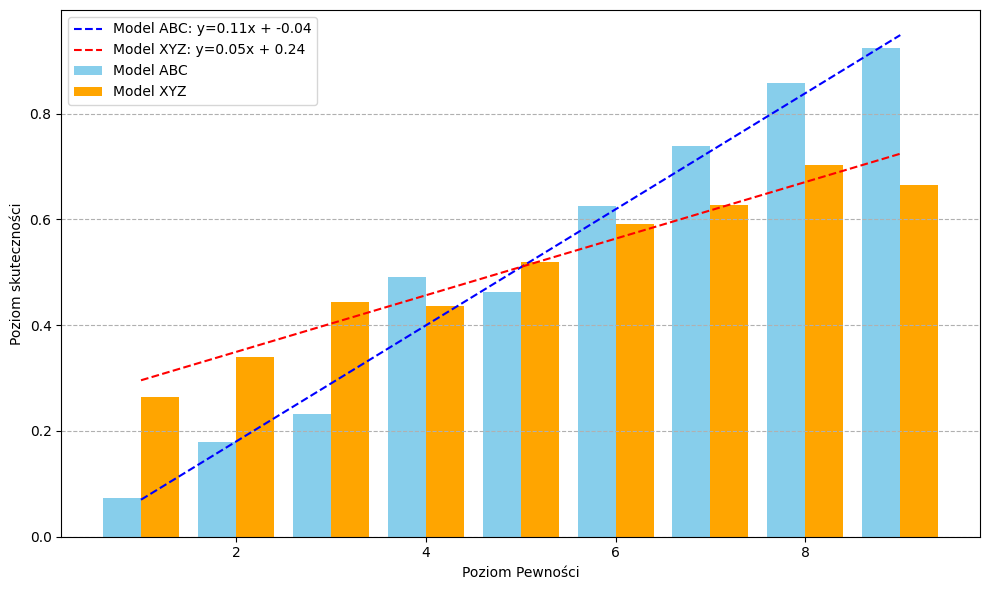

(   OSAD  Liczba_wszystkich  Liczba_gramatycznych  Proporcja_gramatycznych
 0     1                318                    23                 0.072327
 1     2                112                    20                 0.178571
 2     3                 73                    17                 0.232877
 3     4                 57                    28                 0.491228
 4     5                 54                    25                 0.462963
 5     6                 64                    40                 0.625000
 6     7                 88                    65                 0.738636
 7     8                133                   114                 0.857143
 8     9                277                   256                 0.924188,
    OSAD  Liczba_wszystkich  Liczba_gramatycznych  Proporcja_gramatycznych
 0     1                216                    57                 0.263889
 1     2                150                    51                 0.340000
 2     3                

In [18]:
porownaj_dwie_regresje(pewnoscABC, pewnoscXYZ, 'OSAD')

In [19]:
def moderacja_bootstrap(regABC, regXYZ, kolumna_pewnosci='OSAD', trafnosc='Proporcja_gramatycznych', n_boot=1000, seed=36):
    """
    Wykonuje analizƒô moderacji z u≈ºyciem bootstrappingu na danych z dw√≥ch modeli (regABC i regXYZ).
    Zak≈Çada, ≈ºe obie ramki majƒÖ te same kolumny: poziom pewno≈õci i trafno≈õƒá.

    Parametry:
    - regABC, regXYZ: DataFrame'y z kolumnami: poziom pewno≈õci i proporcja trafno≈õci.
    - kolumna_pewnosci: nazwa kolumny z poziomem pewno≈õci.
    - trafnosc: nazwa kolumny z trafno≈õciƒÖ (proporcja gramatycznych).
    - n_boot: liczba pr√≥b bootstrapowych.
    - seed: random seed (dla powtarzalno≈õci).

    Zwraca:
    - ≈örednia interakcja, 95% CI, p-value (empiryczne)
    """

    np.random.seed(seed)
    interakcje = []

    # scal dane z info o modelu
    regABC_ = regABC.copy()
    regABC_['model'] = 'ABC'
    regXYZ_ = regXYZ.copy()
    regXYZ_['model'] = 'XYZ'

    full_df = pd.concat([regABC_, regXYZ_], ignore_index=True)

    for _ in range(n_boot):
        boot = full_df.sample(frac=1, replace=True)
        model = smf.ols(f'{trafnosc} ~ {kolumna_pewnosci} * model', data=boot).fit()

        # nazwa interakcji mo≈ºe siƒô r√≥≈ºniƒá w zale≈ºno≈õci od porzƒÖdku sortowania kategorii
        try:
            b_interakcja = model.params[f'{kolumna_pewnosci}:model[T.XYZ]']
        except KeyError:
            b_interakcja = model.params[[k for k in model.params.keys() if ':' in k][0]]  # fallback

        interakcje.append(b_interakcja)

    interakcje = np.array(interakcje)
    ci_lower = np.percentile(interakcje, 2.5)
    ci_upper = np.percentile(interakcje, 97.5)
    mean_inter = np.mean(interakcje)
    if mean_inter > 0:
        p_empiryczne = 2 * np.mean(interakcje <= 0)
    else:
        p_empiryczne = 2 * np.mean(interakcje >= 0)

    print("üîç Wyniki moderacji z bootstrappingiem:")
    print(f"‚Ä¢ ≈örednia warto≈õƒá interakcji (Œ≤ moderacji): {mean_inter:.4f}")
    print(f"‚Ä¢ 95% przedzia≈Ç ufno≈õci: [{ci_lower:.4f}, {ci_upper:.4f}]")
    print(f"‚Ä¢ Empiryczne p-value: {p_empiryczne:.4f}")




In [20]:
moderacja_bootstrap(regABC, regXYZ)

üîç Wyniki moderacji z bootstrappingiem:
‚Ä¢ ≈örednia warto≈õƒá interakcji (Œ≤ moderacji): -0.0564
‚Ä¢ 95% przedzia≈Ç ufno≈õci: [-0.0751, -0.0417]
‚Ä¢ Empiryczne p-value: 0.0020
